# Per-person negative income tax

Calculate the per-person negative income tax cost depending on the threshold, given a 50% phase-out and no benefit reductions.

*Data: CPS  |  Tax year: 2018  |  Type: Static  |  Author: Max Ghenis*

## Setup

### Imports

In [1]:
import taxcalc as tc
import taxcalc_helpers as tch
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
tc.__version__

'0.20.1'

### Settings

In [3]:
sns.set_style('white')
DPI = 75
mpl.rc('savefig', dpi=DPI)
mpl.rcParams['figure.dpi'] = DPI
mpl.rcParams['figure.figsize'] = 6.4, 4.8  # Default.

In [4]:
mpl.rcParams['font.sans-serif'] = 'Roboto'
mpl.rcParams['font.family'] = 'sans-serif'

# Set title text color to dark gray (https://material.io/color) not black.
TITLE_COLOR = '#212121'
mpl.rcParams['text.color'] = TITLE_COLOR

# Axis titles and tick marks are medium gray.
AXIS_COLOR = '#757575'
mpl.rcParams['axes.labelcolor'] = AXIS_COLOR
mpl.rcParams['xtick.color'] = AXIS_COLOR
mpl.rcParams['ytick.color'] = AXIS_COLOR

# Use Seaborn's default color palette.
# https://stackoverflow.com/q/48958426/1840471 for reproducibility.
sns.set_palette(sns.color_palette())

In [5]:
# Show one decimal in tables.
pd.set_option('precision', 2)

## Data

In [94]:
reform_no_medicaid_medicare = {
    2018: {
        "_BEN_mcaid_repeal": [True],
        "_BEN_mcare_repeal": [True]
    }
}

In [111]:
df = tch.calc_df(records=tc.Records.cps_constructor(),
                 reform=reform_no_medicaid_medicare,
                 year=2018,
                 group_vars=['XTOT', 'nu18', 'aftertax_income'],
                 metric_vars=['aftertax_income', 'XTOT', 'nu18'])

Zero out negative after-tax incomes.

In [112]:
df.aftertax_income.clip_lower(0, inplace=True)
df.aftertax_income_m.clip_lower(0, inplace=True)

Add after-tax income per person.

In [113]:
df['afti_pp'] = df.aftertax_income / df.XTOT

# FIX PHASE-OUT

See https://docs.google.com/spreadsheets/d/1mRYJyGLWf-mXp7GRMH94Cx9ES-MEL1d_5qBfwgE7k-U/edit#gid=0

In [114]:
def phase_out(c, ps, inc):
    return np.where(inc <= 0, c,
                    np.where(inc >= (c / ps), 0,
                             c - (inc * ps)))

In [115]:
def total(c, ps, inc):
    return inc + phase_out(c, ps, inc)

In [116]:
demo = pd.DataFrame({
    'inc': pd.Series(range(0, 300)) * 100
})
demo['nit'] = phase_out(10000, 0.5, demo.inc)
demo['total'] = demo.inc + demo.nit
demo['inc2'] = demo.inc

/home/mghenis/miniconda3/lib/python3.6/site-packages/pandas/plotting/_core.py:1716: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  series.name = label


Text(0.5,1,'$10k guarantee + 50% phase-out')

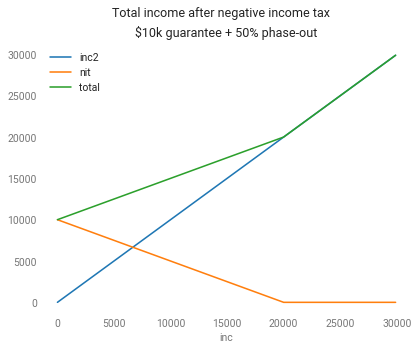

In [117]:
demo.plot(x='inc', y=['inc2', 'nit', 'total'])
sns.despine(left=True, bottom=True)
plt.suptitle('Total income after negative income tax')
plt.title('$10k guarantee + 50% phase-out')

Run for various guarantees.

In [118]:
def nit_total_b(df, guarantee, ps):
    return (phase_out(guarantee, ps, df.afti_pp) * df.XTOT_m).sum() / 1e3

In [129]:
nit_totals = pd.DataFrame({
    'guarantee': pd.Series(range(0, 150)) * 100
})

In [130]:
nit_totals['nit_total_b_50'] = nit_totals.apply(
    lambda x: nit_total_b(df, x.guarantee, 0.5), axis=1)
nit_totals['nit_total_b_33'] = nit_totals.apply(
    lambda x: nit_total_b(df, x.guarantee, 0.33), axis=1)

/home/mghenis/miniconda3/lib/python3.6/site-packages/pandas/plotting/_core.py:1716: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  series.name = label


Text(0.5,1,'Cost of a negative income tax by per-person guaranteed income')

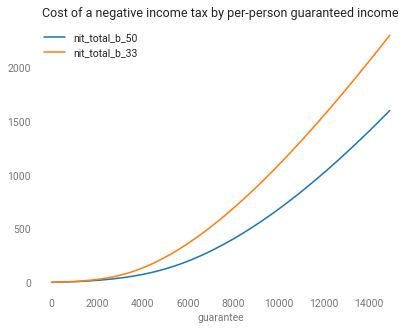

In [136]:
nit_totals.plot(x='guarantee', y=['nit_total_b_50', 'nit_total_b_33'])
# Remove legend.
sns.despine(left=True, bottom=True)
plt.title('Cost of a negative income tax by per-person guaranteed income')

In [132]:
nit_totals[nit_totals.guarantee == 10000]

,guarantee,nit_total_b_50,nit_total_b_33
100,10000,681.13,1091.8


In [138]:
JG_COST = 360.9
nit_totals[nit_totals.nit_total_b_50 < JG_COST].tail(2)

,guarantee,nit_total_b_50,nit_total_b_33
75,7500,344.26,598.15
76,7600,355.63,615.71


In [137]:
df[df.afti_pp < 7500].XTOT_m.sum()

37.244607890000005

In [140]:
df[df.afti_pp < 7500].XTOT_m.sum() / df.XTOT_m.sum()

0.1113065450147292

In [139]:
nit_totals.sample(5)

,guarantee,nit_total_b_50,nit_total_b_33
147,14700,1556.84,2246.97
112,11200,877.91,1363.37
87,8700,492.75,821.53
26,2600,29.78,46.69
4,400,1.71,1.94
